# Slice & preprocess the REU data (3D vars include) for ML tasks
**Authors: Yu Huang, Sungduk Yu, Julius Busecke**

Approximate run time for this notebook:

* 10min (32G mem & 4CPU) for calculating daily mean of one 2D variable and one 3D variable from the original 10-yr 20-min time step data

GitHub repository links: [tutorials for REU dataset](https://github.com/sungdukyu/LEAP_REU_Dataset_Notebook); [LEAP-REU23 Bootcamp](https://github.com/leap-stc/LEAP-bootcamps).


### Install and load python packages

We use [mamba](https://mamba.readthedocs.io/en/latest/installation.html) (instead of conda) to install packages on Hub. Please click the "+" button on the leftup corner to launch a terminal, copy the below commands after "!" and run them on the terminal if you cannot directly import them

In [1]:
# ! mamba install -y pynco pynio pyngl

In [6]:
import gcsfs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cftime

### Load dataset from Google Cloud

#### Open Google Cloud Storage File System


In [7]:
fs = gcsfs.GCSFileSystem()

#### List files in the bucket where the E3SM-MMF dataset is stored


In [8]:
fs.ls("gs://leap-persistent-ro/sungdukyu")

['leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr',
 'leap-persistent-ro/sungdukyu/testing']

#### Open the file you want using xarray


In [9]:
input_vars = ['state_q0001']
output_vars = ['state_q0001']

In [10]:
%%time
def load_vars_xarray(input_vars, output_vars, downsample=False, chunks = True):
    # raw files, not interpolated according to Yu suggestion
    if(chunks):
        mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
        inp = xr.open_dataset(mapper, engine='zarr', chunks={})
        mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
        output = xr.open_dataset(mapper, engine='zarr', chunks={'sample':720})
    else:
        mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
        inp = xr.open_dataset(mapper, engine='zarr')
        mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
        output = xr.open_dataset(mapper, engine='zarr')
    if downsample: # might as well do first
        inp = inp.isel(sample = np.arange(36,len(inp.sample),72)) #  every 1 day
        output = output.isel(sample = np.arange(36,len(output.sample),72))
    ds = inp[input_vars]
    for var in output_vars:
        ds['out_'+var] = output[var]

    time = pd.DataFrame({"ymd":inp.ymd, "tod":inp.tod})
    # rename sample to reformatted time column 
    f = lambda ymd, tod : cftime.DatetimeNoLeap(ymd//10000, ymd%10000//100, ymd%10000%100, tod // 3600, tod%3600 // 60)
    time = time.apply(lambda x: f(x.ymd, x.tod), axis=1)
    ds['sample'] = list(time)
    ds = ds.rename({'sample':'time'})
    ds = ds.assign_coords({'ncol' : ds.ncol})
    return(ds)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


In [11]:
ds = load_vars_xarray(input_vars, output_vars)

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/dataset.py:255: UserWarning: The specified Dask chunks separate the stored chunks along dimension "sample" starting at index 720. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [12]:
ds

<xarray.Dataset>
Dimensions:          (time: 210240, lev: 60, ncol: 384)
Coordinates:
  * time             (time) object 0001-02-01 00:00:00 ... 0009-01-31 23:40:00
  * ncol             (ncol) int64 0 1 2 3 4 5 6 ... 377 378 379 380 381 382 383
Dimensions without coordinates: lev
Data variables:
    state_q0001      (time, lev, ncol) float64 dask.array<chunksize=(1512, 60, 384), meta=np.ndarray>
    out_state_q0001  (time, lev, ncol) float64 dask.array<chunksize=(720, 60, 384), meta=np.ndarray>
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [13]:
ds.out_state_q0001.isel(time = 100, ncol = 224).values

array([1.47712187e-06, 1.47798462e-06, 1.41136492e-06, 1.30763251e-06,
       1.21582604e-06, 1.10077080e-06, 9.99852140e-07, 9.14775678e-07,
       8.76119810e-07, 8.77274171e-07, 8.76479312e-07, 8.70126286e-07,
       9.45010369e-07, 9.88926094e-07, 9.89902409e-07, 9.59183018e-07,
       7.25672304e-07, 4.26516077e-07, 7.53810386e-07, 2.12400144e-06,
       2.99344380e-06, 4.42314619e-06, 1.36247780e-05, 4.75908748e-05,
       1.00766310e-04, 1.83599907e-04, 2.33129703e-04, 2.26918193e-04,
       2.11690556e-04, 1.95317539e-04, 1.97591751e-04, 2.35623923e-04,
       2.91075629e-04, 3.46574417e-04, 4.72720123e-04, 7.63886064e-04,
       1.14249770e-03, 1.58145221e-03, 1.94555088e-03, 2.38802931e-03,
       2.88496878e-03, 3.19410941e-03, 3.37221348e-03, 3.36810409e-03,
       3.44698713e-03, 3.63333526e-03, 4.50600857e-03, 7.15934851e-03,
       9.53790861e-03, 1.06780596e-02, 1.15061982e-02, 1.25035023e-02,
       1.29627230e-02, 1.37752332e-02, 1.43375990e-02, 1.53513098e-02,
      

### Convert the dimension/coordinate of column index to structured lat, lon 

#### Open a file that stores grid information, and check the original lat, lon information

In [14]:
# grid info
mapper = fs.get_mapper("gs://leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr")
ds_grid = xr.open_dataset(mapper, engine='zarr')
ds_grid

<xarray.Dataset>
Dimensions:  (ncol: 384, ilev: 61, lev: 60)
Dimensions without coordinates: ncol, ilev, lev
Data variables:
    P0       float64 ...
    area     (ncol) float64 ...
    hyai     (ilev) float64 ...
    hyam     (lev) float64 ...
    hybi     (ilev) float64 ...
    hybm     (lev) float64 ...
    lat      (ncol) float64 ...
    lon      (ncol) float64 ...
Attributes: (12/19)
    Conventions:       CF-1.7
    case:              E3SM_ML.GNUGPU.F2010-MMF1.ne4pg2_ne4pg2
    contact:           e3sm-data-support@listserv.llnl.gov
    fv_nphys:          2
    git_version:       4108bd8c11
    history:           created on 01/13/23 15:30:04
    ...                ...
    source:            E3SM Atmosphere Model
    source_id:         4108bd8c11
    time_period_freq:  month_1
    title:             EAM History file information
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    username:          sungduk

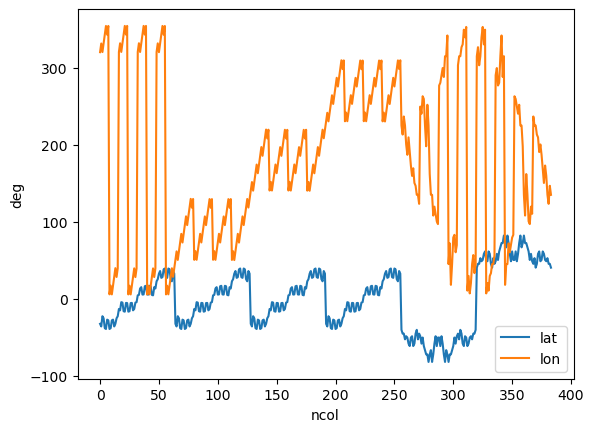

In [15]:
fig, ax = plt.subplots()
ds_grid['lat'].plot(label='lat', ax=ax)
ds_grid['lon'].plot(label='lon', ax=ax)
ax.set_ylabel('deg')
ax.legend()

In [16]:
print('column number is ',len(np.unique(ds_grid.ncol.values)))
print('if each lat occured in the data can be paired with a lon, the (lat,lon) grid number is', len(np.unique(ds_grid.lat.values))*len(np.unique(ds_grid.lon.values)))
np.unique(ds_grid.lon.values.round(2))

column number is  384
if each lat occured in the data can be paired with a lon, the (lat,lon) grid number is 17313


array([  5.63,   5.65,   5.68,   5.73,   6.97,  10.54,  16.89,  16.91,
        16.96,  17.02,  18.06,  20.4 ,  28.15,  28.2 ,  28.31,  28.47,
        29.62,  33.28,  39.4 ,  39.46,  39.56,  39.73,  45.  ,  50.27,
        50.44,  50.54,  50.6 ,  56.72,  60.38,  61.53,  61.69,  61.8 ,
        61.85,  69.6 ,  71.94,  72.98,  73.04,  73.09,  73.11,  79.46,
        83.03,  84.27,  84.32,  84.35,  84.37,  95.63,  95.65,  95.68,
        95.73,  96.97, 100.54, 106.89, 106.91, 106.96, 107.02, 108.06,
       110.4 , 118.15, 118.2 , 118.31, 118.47, 119.62, 123.28, 129.4 ,
       129.46, 129.56, 129.73, 135.  , 140.27, 140.44, 140.54, 140.6 ,
       146.72, 150.38, 151.53, 151.69, 151.8 , 151.85, 159.6 , 161.94,
       162.98, 163.04, 163.09, 163.11, 169.46, 173.03, 174.27, 174.32,
       174.35, 174.37, 185.63, 185.65, 185.68, 185.73, 186.97, 190.54,
       196.89, 196.91, 196.96, 197.02, 198.06, 200.4 , 208.15, 208.2 ,
       208.31, 208.47, 209.62, 213.28, 219.4 , 219.46, 219.56, 219.73,
      

#### Change the geo-coordinate from column index to multi-index (lat, lon) 

In [17]:
# original lat and lon info
lat = ds_grid.lat.values.round(2) 
lon = ds_grid.lon.values.round(2) 

# merge the original grid info with the dataset containing atmos variables
ds_multiindex = ds.copy()
ds_multiindex['lat'] = (('ncol'),lat.T) # (('sample', 'ncol'),lat.T)
ds_multiindex['lon'] = (('ncol'),lon.T)

# use multi-index and unstack function to convert the 1D dimension/coordinate ncol to 2D lat and lon
ds_multiindex['index_id'] = ds_multiindex.coords['ncol'].copy()
ds_multiindex.coords['ncol'] = pd.MultiIndex.from_arrays([lat, lon], names=['lat', 'lon'])
ds_multiindex = ds_multiindex.unstack('ncol')

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/no

In [18]:
ds_multiindex

<xarray.Dataset>
Dimensions:          (lat: 52, lon: 180, time: 210240, lev: 60)
Coordinates:
  * lat              (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
  * lon              (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
  * time             (time) object 0001-02-01 00:00:00 ... 0009-01-31 23:40:00
Dimensions without coordinates: lev
Data variables:
    state_q0001      (time, lev, lat, lon) float64 dask.array<chunksize=(1512, 60, 52, 180), meta=np.ndarray>
    out_state_q0001  (time, lev, lat, lon) float64 dask.array<chunksize=(720, 60, 52, 180), meta=np.ndarray>
    index_id         (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

#### Select the domain and unstack variables as wanted

In [19]:
# slice the data as wanted, only keep the variables and domain that you're interested in
# here I only keep the data within \pm 45 degree in lat
ds_sel = ds_multiindex[['state_q0001', 'index_id','out_state_q0001']].sel(lat = slice(-10,0),lon = slice(300,310))
#ds_sel
ds_sel

<xarray.Dataset>
Dimensions:          (time: 210240, lev: 60, lat: 4, lon: 5)
Coordinates:
  * lat              (lat) float64 -5.61 -5.41 -5.01 -4.43
  * lon              (lon) float64 303.3 309.4 309.5 309.6 309.7
  * time             (time) object 0001-02-01 00:00:00 ... 0009-01-31 23:40:00
Dimensions without coordinates: lev
Data variables:
    state_q0001      (time, lev, lat, lon) float64 dask.array<chunksize=(1512, 60, 4, 5), meta=np.ndarray>
    index_id         (lat, lon) float64 nan nan nan nan ... 223.0 nan nan nan
    out_state_q0001  (time, lev, lat, lon) float64 dask.array<chunksize=(720, 60, 4, 5), meta=np.ndarray>
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

For ML purpose, we treat each column on each day as one sample entry, so it's better NOT to convert the dimension to lat and lon for ML tasks, because it will increase the dimension size and lead to many NaNs.

Instead, we want to select data based on lat and lon information, but use original column index as the data dimension.

In [20]:
# get the column index from the above dataset
iid = ds_sel.index_id.values
iid = iid[~np.isnan(iid)].astype(int)
print(iid)
ds_sel2 = ds.sel(ncol = iid)
ds_sel2

[223]


<xarray.Dataset>
Dimensions:          (time: 210240, lev: 60, ncol: 1)
Coordinates:
  * time             (time) object 0001-02-01 00:00:00 ... 0009-01-31 23:40:00
  * ncol             (ncol) int64 223
Dimensions without coordinates: lev
Data variables:
    state_q0001      (time, lev, ncol) float64 dask.array<chunksize=(1512, 60, 1), meta=np.ndarray>
    out_state_q0001  (time, lev, ncol) float64 dask.array<chunksize=(720, 60, 1), meta=np.ndarray>
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

# creating q_tend as variable and saving it

In [21]:
# #sammy's code to downsample code
# downsample = False
# if downsample:
#     yeet = ds.isel(time=np.arange(0, len(ds.time), 72))

In [22]:
#selecting only one year
ds_sel3 = ds_sel2.sel(time='0001-07')
#ds_sel3.out_state_q0001.values
ds_sel3

<xarray.Dataset>
Dimensions:          (time: 2232, lev: 60, ncol: 1)
Coordinates:
  * time             (time) object 0001-07-01 00:00:00 ... 0001-07-31 23:40:00
  * ncol             (ncol) int64 223
Dimensions without coordinates: lev
Data variables:
    state_q0001      (time, lev, ncol) float64 dask.array<chunksize=(1296, 60, 1), meta=np.ndarray>
    out_state_q0001  (time, lev, ncol) float64 dask.array<chunksize=(720, 60, 1), meta=np.ndarray>
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [23]:
#calculate qtend for all time steps
ds_sel3['q_tend'] = (ds_sel3['out_state_q0001']-ds_sel3['state_q0001'])/1200

In [24]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    ds_processed = ds_sel3.load()

[########################################] | 100% Completed | 7.90 ss


In [25]:
ds_processed

<xarray.Dataset>
Dimensions:          (time: 2232, lev: 60, ncol: 1)
Coordinates:
  * time             (time) object 0001-07-01 00:00:00 ... 0001-07-31 23:40:00
  * ncol             (ncol) int64 223
Dimensions without coordinates: lev
Data variables:
    state_q0001      (time, lev, ncol) float64 1.281e-06 1.205e-06 ... 0.01073
    out_state_q0001  (time, lev, ncol) float64 1.281e-06 1.205e-06 ... 0.01071
    q_tend           (time, lev, ncol) float64 0.0 0.0 ... -1.274e-08 -1.248e-08
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [26]:
#save q_tend non-normalized variable as netcdf
if False:
    ds_processed.to_netcdf('../equation_discovery/variables/q_tend_train.nc')
else:
    q_tend = xr.open_dataset('../equation_discovery/variables/q_tend_train.nc')

# scaling units of q_tend--dont actually need this

In [22]:
#sungduks code to change the units of q_tend to J/kg
#'ptend_q0001':    ('lev', (2.501e6 + 3.337e5)*np.ones(mlo.dims['lev'])), # J/kg
qtend_units  = (2.501e6 + 3.337e5)*np.ones(ds_processed.dims['lev'])
qtend_units.shape

(60,)

In [23]:
#create a dataset with a variable array with the same dimension as the lev dims in the original one
#putting False makes sure the code doesn't run and will open the file instead
if False:
    qtend_scale = xr.Dataset({'ptend_q0001':    ('lev', (2.501e6 + 3.337e5)*np.ones(ds_processed.dims['lev']))}) #j/kg
    qtend_scale.to_netcdf('./norm_factors/qtend_scale.nc')

else:
    qtend_scale = xr.open_dataset('./norm_factors/qtend_scale.nc')

In [24]:
qtend_scale.ptend_q0001.shape, ds_processed.q_tend.shape

((60,), (2232, 60, 1))

In [25]:
(qtend_scale.ptend_q0001 * ds_processed.q_tend).shape

(60, 2232, 1)

In [26]:
#copy ds_processed and change units of q
ds_processed2 = ds_processed.copy()
ds_processed2['q_tend'] = qtend_scale.ptend_q0001 * ds_processed.q_tend
ds_processed2

<xarray.Dataset>
Dimensions:          (time: 2232, lev: 60, ncol: 1)
Coordinates:
  * time             (time) object 0001-07-01 00:00:00 ... 0001-07-31 23:40:00
  * ncol             (ncol) int64 223
Dimensions without coordinates: lev
Data variables:
    state_q0001      (time, lev, ncol) float64 1.281e-06 1.205e-06 ... 0.01073
    out_state_q0001  (time, lev, ncol) float64 1.281e-06 1.205e-06 ... 0.01071
    q_tend           (lev, time, ncol) float64 0.0 0.0 0.0 ... -0.02863 -0.03536
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [27]:
#save variable as netcdf
if False:
    ds_processed2.to_netcdf('../equation_discovery/variables/q_tend_calc.nc')
else:
    q_tend_calc = xr.open_dataset('../equation_discovery/variables/q_tend_calc.nc')